<a href="https://colab.research.google.com/github/greyhound101/Multihead_attention/blob/master/alexnet_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive
Mounted at /content/gdrive


In [3]:
!nvidia-smi

Wed Oct 27 11:25:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import zipfile
with zipfile.ZipFile('/content/gdrive/MyDrive/2020_patientwise_split.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [5]:
import zipfile
with zipfile.ZipFile('/content/gdrive/MyDrive/brats_2020_classification.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [6]:
import zipfile
import h5py
from tensorflow.keras.optimizers import *
import cv2
from tensorflow.keras.utils import to_categorical
import glob, os
from matplotlib import pyplot as plt
import h5py
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm
import time
import gc
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

In [7]:
!pip install pytorch2keras

     |████████████████████████████████| 12.7 MB 6.5 MB/s 
  Created wheel for pytorch2keras: filename=pytorch2keras-0.2.4-py3-none-any.whl size=29678 sha256=ffd2c3aae049b8e0372cae656f661892c8c81015fac9326d923cc5081a05a85d
  Stored in directory: /root/.cache/pip/wheels/72/4e/ee/8c004883e677ab4283783ffd9433ecf595327889dd367c79b1
  Created wheel for onnx2keras: filename=onnx2keras-0.0.24-py3-none-any.whl size=24593 sha256=aabff95487923c53e9827e3276d2095767b34d84969c5d91d6b039546b6ad3f5
  Stored in directory: /root/.cache/pip/wheels/21/29/29/227fc9f8fed234b12169ae41f979cfadf1dcdbe1b370a5bbb5
Successfully built pytorch2keras onnx2keras


In [9]:


from torchvision import transforms, datasets, models
import torch
import numpy as np
from pytorch2keras import pytorch_to_keras 

In [10]:
from tensorflow import keras
from keras.activations import softmax
from tensorflow.keras import backend as K
import tensorflow as tf
class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape
class abc(Layer):
    def __init__(self,inr,size,mo,up,s,**kwargs):
        super(abc, self).__init__(**kwargs)
        self.inr=inr
        self.s=s
        self.mo=mo
        self.up=up
        self.size=size
    def get_config(self):
        base_config = super(abc, self).get_config()

    def build(self, input_shape):
        super(abc, self).build(input_shape)
        self.cv2 = Conv2D(self.inr,(self.s,self.s))
        self.cv1 = Conv2D(self.inr,1)
        self.up = UpSampling2D(interpolation='bilinear',size=(self.up,self.up))
        self.dns1=Dense(1)
    def call(self, img,y):
        y = self.up(y)
        y = self.cv1(y)
        x = self.cv2(img)
        x = Add()([y,x])
        x = ReLU()(x)
        x = K.mean(x,axis=-1)
        x = Reshape((self.size,self.size,1))(x)
        
        map = softmax(x,axis=[2,3])


        return Multiply()([img,map])
class SpatialGate(keras.layers.Layer):
    def __init__(self,**kwargs):
        super(SpatialGate, self).__init__(**kwargs)

    def get_config(self):
        base_config = super(SpatialGate, self).get_config()

    def build(self, input_shape):
        super(SpatialGate, self).build(input_shape)
        self.cv2 = Conv2D(1,1)
    def call(self, img):
        
        img_avg = K.expand_dims(K.mean(img,-1),-1)
        img_max = K.expand_dims(K.max(img,-1),-1)
        total = Concatenate(-1)([img_avg,img_max])
        x = self.cv2(total)
        x = keras.activations.sigmoid(x)

        return tf.math.multiply(img,x)
class ChannelGate(keras.layers.Layer):
    def __init__(self,inr,ratio,**kwargs):
        super(ChannelGate, self).__init__(**kwargs)
        self.inr=inr
        self.ratio=ratio

    def get_config(self):
        base_config = super(abc, self).get_config()

    def build(self, input_shape):
        super(ChannelGate, self).build(input_shape)
        self.dns1 = Dense(self.inr/self.ratio,activation='relu')
        self.dns2 = Dense(self.inr)
        self.spt = SpatialGate()
    def call(self, img):
        
        img_avg = self.dns2(self.dns1(GlobalAveragePooling2D()(img)))
        img_max = self.dns2(self.dns1(GlobalMaxPooling2D()(img)))
        x = keras.activations.sigmoid(img_max+img_avg)
        x = Reshape((1,1,self.inr))(x)

        return self.spt(tf.math.multiply(img,x))

from tensorflow import keras 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
def load_model():   
  
  K.clear_session() 
  mod=models.alexnet(pretrained=True)
  input_np = np.random.uniform(0, 1, (1, 3, 224,224))
  input_var = torch.FloatTensor(input_np)

  k_model = pytorch_to_keras(mod, input_var, [(3, 224,224,)], verbose=True,name_policy='keep',change_ordering='HWC')
  mod=k_model
  out_1=mod.layers[-2].output
  out=Dense(2,activation='softmax')(out_1)
  model=Model(inputs=mod.input,outputs=out)
  return model


from tensorflow import keras 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow import keras 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *
from tensorflow.keras import applications as a
# def load_model():   
    
#   d = Concatenate()([mod.layers[-8].output,mod.layers[-9].output]) #(13,13)
#   d = Conv2D(512,1)(d)

#   a = mod.layers[-10].output #(26,26)
#   a = Conv2D(512,(2,2))(a)
#   a = abc(inr=8,mo=512,up=2,size=12,s=1)(a,d)
#   a = LayerNormalization()(a)
#   a = Reshape((12,12,512,))(a)

#   b = mod.layers[7].output #(56,56)
#   b = Conv2D(256,(4,4))(b)
#   b = abc(inr=8,mo=256,up=4,size=24,s=1)(b,d)
#   b = LayerNormalization()(b)
#   b = Reshape((24,24,256))(b)

#   a = UpSampling2D(size=(2,2))(a)
#   d = UpSampling2D(size=(4,4))(d)
    
#   conc=Concatenate(axis=-1)([a,b,d])
#   conc = GlobalMaxPooling2D()(conc)

#   conc = Dense(2, activation="softmax")(conc) 
  
#   mod=Model(inputs=mod.input,outputs=conc)
#   return mod


import keras
import pandas as pd
from keras.applications.nasnet import NASNetMobile, preprocess_input
import imgaug as ia
from imgaug import augmenters as iaa

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result
def Hflip( images):
		seq = iaa.Sequential([iaa.Fliplr(1.0)])
		return seq.augment_images(images)
def Vflip( images):
		seq = iaa.Sequential([iaa.Flipud(1.0)])
		return seq.augment_images(images)
def noise(images):
    ls=[]
    for i in images:
        x = np.random.normal(loc=0, scale=0.05, size=(299,299,3))
        ls.append(i+x)
    return ls
def rotate(images):
    ls=[]
    for angle in range(-15,15,5):
        for image in images:
            ls.append(rotate_image(image,angle))
    return ls
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, images, labels, batch_size=64, image_dimensions = (96 ,96 ,3), shuffle=False, augment=False):
    self.labels       = labels              # array of labels
    self.images = images        # array of image paths
    self.batch_size   = batch_size          # batch size
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(self.labels.shape[0] / self.batch_size))

  def on_epoch_end(self):
    self.indexes = np.arange(self.labels.shape[0])

  def __getitem__(self, index):
		# selects indices of data for next batch
    indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
    # select data and load images
    labels = self.labels.loc[indexes]
    img = [self.images[k].astype(np.float32) for k in indexes]
    imgH=Hflip(img)
    imgV=Vflip(img)
    imgR=rotate(img)
    images=[]
    images.extend(imgH)
    images.extend(imgV)
    images.extend(imgR)
    lbl=labels.copy()
    labels=pd.DataFrame()
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    #images = np.array([preprocess_input(img) for img in images])
    return np.asarray(images), labels.values


best_accuracy_last={}
final_accuracy_last={}
history_last={}
answers_last={}
predictions_last={}
predictions_last_best={}
times_last={}


#shuffle samples
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]



#change targets
def change(img):
    resized = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA )
    return resized




#get train and test splits
def get_trn_tst(df,tst_fold):
  idx=np.asarray(df['fold'])
  y=np.asarray(df['label'])
  y-=1
  img=np.asarray(df['images'])
  img1=[]
  for i in range(len(img)):
        img1.append(change(img[i]))
  img1=np.asarray(img1)
  del([img])
  gc.collect()
  trn_y=np.asarray(y[(idx!=tst_fold)])
  trn_img=np.asarray(img1[(idx!=tst_fold)])
  tst_y=np.asarray(y[(idx==tst_fold)])
  tst_img=img1[idx==tst_fold]
  trn_img=np.repeat(trn_img.reshape((trn_img.shape[0],224,224,1)),3,axis=3)
  tst_img=np.repeat(tst_img.reshape((tst_img.shape[0],224,224,1)),3,axis=3)
  return (trn_img.copy(),trn_y.copy()),(tst_img.copy(),tst_y.copy())


In [11]:
from pathlib import Path
def get_trn_tst(index):
    index=str(index-1)
    test=[]
    for i in np.load('/content/test_'+index+'.npy',allow_pickle=True):
        if Path("/content/"+i+"_LGG1.npy").is_file():
            test.append("/content/"+i+"_LGG1.npy")
        if Path("/content/"+i+"_LGG2.npy").is_file():
            test.append("/content/"+i+"_LGG2.npy")
        if Path("/content/"+i+"_LGG3.npy").is_file():
            test.append("/content/"+i+"_LGG3.npy")
        if Path("/content/"+i+"_HGG.npy").is_file():
            test.append("/content/"+i+"_HGG.npy")
    train=[]
    for i in np.load('/content/train_'+index+'.npy',allow_pickle=True):
        if Path("/content/"+i+"_LGG1.npy").is_file():
            train.append("/content/"+i+"_LGG1.npy")
        if Path("/content/"+i+"_LGG2.npy").is_file():
            train.append("/content/"+i+"_LGG2.npy")
        if Path("/content/"+i+"_LGG3.npy").is_file():
            train.append("/content/"+i+"_LGG3.npy")
        if Path("/content/"+i+"_HGG.npy").is_file():
            train.append("/content/"+i+"_HGG.npy")
    return train,test

In [12]:
def unison_shuffled_copies(a):
    p = np.random.permutation(len(a))
    return list(np.asarray(a)[p])

In [13]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, images, batch_size=64, image_dimensions = (96 ,96 ,3), shuffle=False, augment=False):
    self.images = images        # array of image paths
    self.batch_size   = batch_size          # batch size
    self.augment=augment
    self.on_epoch_end()

  def __len__(self):
    return int(np.ceil(len(self.images) / self.batch_size))

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.images))

  def __getitem__(self, index):
    max=(index + 1) * self.batch_size
    if max>len(self.images):
        max=len(self.images)
    indexes = self.images[index * self.batch_size : max]
    img = [  ]
    for k in indexes:
        img.append(np.repeat(np.load(k).reshape((224,224,1)),3,axis=-1).astype(np.float32))
    imgH=Hflip(img)
    imgV=Vflip(img)
    imgR=rotate(img)
    images=img
    if self.augment:
        images.extend(imgH)
        images.extend(imgV)
        images.extend(imgR)
    
    labels=[]
    for i in indexes:
        cls1=i.split('_')[-1].split('.')[0]
        if cls1[-1]=='G':
            labels.append([1,0])
        else:
            labels.append([0,1])
    if self.augment:
        labels*=9
        labels=np.stack(labels)
    return np.asarray(images), np.asarray(labels)



In [14]:
def unison_shuffled_copies(a):
    p = np.random.permutation(len(a))
    return list(np.asarray(a)[p])

In [15]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, images, batch_size=64, image_dimensions = (96 ,96 ,3), shuffle=False, augment=False):
    self.images = images        # array of image paths
    self.batch_size   = batch_size          # batch size
    self.augment=augment
    self.on_epoch_end()

  def __len__(self):
    return int(np.ceil(len(self.images) / self.batch_size))

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.images))

  def __getitem__(self, index):
    max=(index + 1) * self.batch_size
    if max>len(self.images):
        max=len(self.images)
    indexes = self.images[index * self.batch_size : max]
    img = [  ]
    for k in indexes:
        img.append(np.repeat(np.load(k).reshape((224,224,1)),3,axis=-1).astype(np.float32))
    imgH=Hflip(img)
    imgV=Vflip(img)
    imgR=rotate(img)
    images=img
    if self.augment:
        images.extend(imgH)
        images.extend(imgV)
        images.extend(imgR)
    
    labels=[]
    for i in indexes:
        cls1=i.split('_')[-1].split('.')[0]
        if cls1[-1]=='G':
            labels.append([1,0])
        else:
            labels.append([0,1])
    if self.augment:
        labels*=9
        labels=np.stack(labels)
    return np.asarray(images), np.asarray(labels)



Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

INFO:pytorch2keras:Converter is called.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
DEBUG:pytorch2keras:Input_names:
DEBUG:pytorch2keras:['input_0']
DEBUG:pytorch2keras:Output_names:
DEBUG:pytorch2keras:['output_0']


graph(%input_0 : Float(1, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cpu),
      %features.0.weight : Float(64, 3, 11, 11, strides=[363, 121, 11, 1], requires_grad=1, device=cpu),
      %features.0.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %features.3.weight : Float(192, 64, 5, 5, strides=[1600, 25, 5, 1], requires_grad=1, device=cpu),
      %features.3.bias : Float(192, strides=[1], requires_grad=1, device=cpu),
      %features.6.weight : Float(384, 192, 3, 3, strides=[1728, 9, 3, 1], requires_grad=1, device=cpu),
      %features.6.bias : Float(384, strides=[1], requires_grad=1, device=cpu),
      %features.8.weight : Float(256, 384, 3, 3, strides=[3456, 9, 3, 1], requires_grad=1, device=cpu),
      %features.8.bias : Float(256, strides=[1], requires_grad=1, device=cpu),
      %features.10.weight : Float(256, 256, 3, 3, strides=[2304, 9, 3, 1], requires_grad=1, device=cpu),
      %features.10.bias : Float(256, strides=[1], requires_gr

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:[(3, 224, 224)]
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> input_0.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> output_0.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight features.0.weight with shape (64, 3, 11, 11).
DEBUG:onnx2keras:Found weight features.0.bias with shape (64,).
DEBUG:onnx2keras:Found weight features.3.weight with shape (192, 64, 5, 5).
DEBUG:onnx2keras:Found weight features.3.bias with shape (192,).
DEBUG:onnx2keras:Found weight features.6.weight with shape (384, 192, 3, 3).
DEBUG:onnx2keras:Found weight features.6.bias with shape (384,).
DEBUG:onnx2keras:Found weight features.8.weight with shape (256, 384, 3, 3).
DEBUG:onnx2keras:Found weight features.8.bias with shape (256,).
DEBUG:onnx2keras:Found weight features.10.weight with shape (256, 256, 3, 3).
DEBUG:onnx2keras:Found weight features.10.bias with shape (256,)

training


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
DEBUG:h5py._conv:Creating converter from 5 to 3
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuS

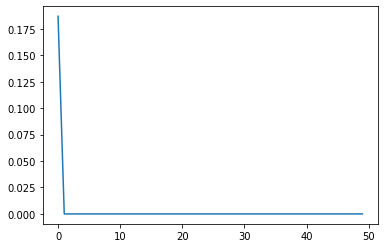

1.0


INFO:pytorch2keras:Converter is called.
DEBUG:pytorch2keras:Input_names:
DEBUG:pytorch2keras:['input_0']
DEBUG:pytorch2keras:Output_names:
DEBUG:pytorch2keras:['output_0']


graph(%input_0 : Float(1, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cpu),
      %features.0.weight : Float(64, 3, 11, 11, strides=[363, 121, 11, 1], requires_grad=1, device=cpu),
      %features.0.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %features.3.weight : Float(192, 64, 5, 5, strides=[1600, 25, 5, 1], requires_grad=1, device=cpu),
      %features.3.bias : Float(192, strides=[1], requires_grad=1, device=cpu),
      %features.6.weight : Float(384, 192, 3, 3, strides=[1728, 9, 3, 1], requires_grad=1, device=cpu),
      %features.6.bias : Float(384, strides=[1], requires_grad=1, device=cpu),
      %features.8.weight : Float(256, 384, 3, 3, strides=[3456, 9, 3, 1], requires_grad=1, device=cpu),
      %features.8.bias : Float(256, strides=[1], requires_grad=1, device=cpu),
      %features.10.weight : Float(256, 256, 3, 3, strides=[2304, 9, 3, 1], requires_grad=1, device=cpu),
      %features.10.bias : Float(256, strides=[1], requires_gr

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:[(3, 224, 224)]
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> input_0.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> output_0.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight features.0.weight with shape (64, 3, 11, 11).
DEBUG:onnx2keras:Found weight features.0.bias with shape (64,).
DEBUG:onnx2keras:Found weight features.3.weight with shape (192, 64, 5, 5).
DEBUG:onnx2keras:Found weight features.3.bias with shape (192,).
DEBUG:onnx2keras:Found weight features.6.weight with shape (384, 192, 3, 3).
DEBUG:onnx2keras:Found weight features.6.bias with shape (384,).
DEBUG:onnx2keras:Found weight features.8.weight with shape (256, 384, 3, 3).
DEBUG:onnx2keras:Found weight features.8.bias with shape (256,).
DEBUG:onnx2keras:Found weight features.10.weight with shape (256, 256, 3, 3).
DEBUG:onnx2keras:Found weight features.10.bias with shape (256,)

training


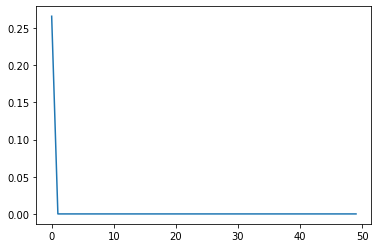

1.0


INFO:pytorch2keras:Converter is called.
DEBUG:pytorch2keras:Input_names:
DEBUG:pytorch2keras:['input_0']
DEBUG:pytorch2keras:Output_names:
DEBUG:pytorch2keras:['output_0']


graph(%input_0 : Float(1, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cpu),
      %features.0.weight : Float(64, 3, 11, 11, strides=[363, 121, 11, 1], requires_grad=1, device=cpu),
      %features.0.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %features.3.weight : Float(192, 64, 5, 5, strides=[1600, 25, 5, 1], requires_grad=1, device=cpu),
      %features.3.bias : Float(192, strides=[1], requires_grad=1, device=cpu),
      %features.6.weight : Float(384, 192, 3, 3, strides=[1728, 9, 3, 1], requires_grad=1, device=cpu),
      %features.6.bias : Float(384, strides=[1], requires_grad=1, device=cpu),
      %features.8.weight : Float(256, 384, 3, 3, strides=[3456, 9, 3, 1], requires_grad=1, device=cpu),
      %features.8.bias : Float(256, strides=[1], requires_grad=1, device=cpu),
      %features.10.weight : Float(256, 256, 3, 3, strides=[2304, 9, 3, 1], requires_grad=1, device=cpu),
      %features.10.bias : Float(256, strides=[1], requires_gr

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:[(3, 224, 224)]
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> input_0.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> output_0.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight features.0.weight with shape (64, 3, 11, 11).
DEBUG:onnx2keras:Found weight features.0.bias with shape (64,).
DEBUG:onnx2keras:Found weight features.3.weight with shape (192, 64, 5, 5).
DEBUG:onnx2keras:Found weight features.3.bias with shape (192,).
DEBUG:onnx2keras:Found weight features.6.weight with shape (384, 192, 3, 3).
DEBUG:onnx2keras:Found weight features.6.bias with shape (384,).
DEBUG:onnx2keras:Found weight features.8.weight with shape (256, 384, 3, 3).
DEBUG:onnx2keras:Found weight features.8.bias with shape (256,).
DEBUG:onnx2keras:Found weight features.10.weight with shape (256, 256, 3, 3).
DEBUG:onnx2keras:Found weight features.10.bias with shape (256,)

training


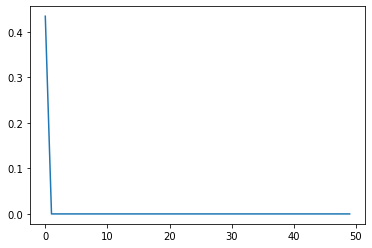

1.0


INFO:pytorch2keras:Converter is called.
DEBUG:pytorch2keras:Input_names:
DEBUG:pytorch2keras:['input_0']
DEBUG:pytorch2keras:Output_names:
DEBUG:pytorch2keras:['output_0']


graph(%input_0 : Float(1, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cpu),
      %features.0.weight : Float(64, 3, 11, 11, strides=[363, 121, 11, 1], requires_grad=1, device=cpu),
      %features.0.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %features.3.weight : Float(192, 64, 5, 5, strides=[1600, 25, 5, 1], requires_grad=1, device=cpu),
      %features.3.bias : Float(192, strides=[1], requires_grad=1, device=cpu),
      %features.6.weight : Float(384, 192, 3, 3, strides=[1728, 9, 3, 1], requires_grad=1, device=cpu),
      %features.6.bias : Float(384, strides=[1], requires_grad=1, device=cpu),
      %features.8.weight : Float(256, 384, 3, 3, strides=[3456, 9, 3, 1], requires_grad=1, device=cpu),
      %features.8.bias : Float(256, strides=[1], requires_grad=1, device=cpu),
      %features.10.weight : Float(256, 256, 3, 3, strides=[2304, 9, 3, 1], requires_grad=1, device=cpu),
      %features.10.bias : Float(256, strides=[1], requires_gr

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:[(3, 224, 224)]
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> input_0.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> output_0.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight features.0.weight with shape (64, 3, 11, 11).
DEBUG:onnx2keras:Found weight features.0.bias with shape (64,).
DEBUG:onnx2keras:Found weight features.3.weight with shape (192, 64, 5, 5).
DEBUG:onnx2keras:Found weight features.3.bias with shape (192,).
DEBUG:onnx2keras:Found weight features.6.weight with shape (384, 192, 3, 3).
DEBUG:onnx2keras:Found weight features.6.bias with shape (384,).
DEBUG:onnx2keras:Found weight features.8.weight with shape (256, 384, 3, 3).
DEBUG:onnx2keras:Found weight features.8.bias with shape (256,).
DEBUG:onnx2keras:Found weight features.10.weight with shape (256, 256, 3, 3).
DEBUG:onnx2keras:Found weight features.10.bias with shape (256,)

training


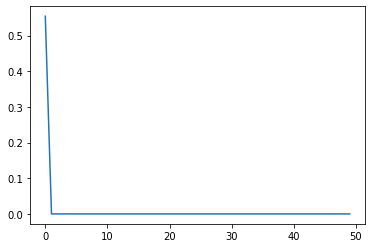

1.0


INFO:pytorch2keras:Converter is called.
DEBUG:pytorch2keras:Input_names:
DEBUG:pytorch2keras:['input_0']
DEBUG:pytorch2keras:Output_names:
DEBUG:pytorch2keras:['output_0']


graph(%input_0 : Float(1, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cpu),
      %features.0.weight : Float(64, 3, 11, 11, strides=[363, 121, 11, 1], requires_grad=1, device=cpu),
      %features.0.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %features.3.weight : Float(192, 64, 5, 5, strides=[1600, 25, 5, 1], requires_grad=1, device=cpu),
      %features.3.bias : Float(192, strides=[1], requires_grad=1, device=cpu),
      %features.6.weight : Float(384, 192, 3, 3, strides=[1728, 9, 3, 1], requires_grad=1, device=cpu),
      %features.6.bias : Float(384, strides=[1], requires_grad=1, device=cpu),
      %features.8.weight : Float(256, 384, 3, 3, strides=[3456, 9, 3, 1], requires_grad=1, device=cpu),
      %features.8.bias : Float(256, strides=[1], requires_grad=1, device=cpu),
      %features.10.weight : Float(256, 256, 3, 3, strides=[2304, 9, 3, 1], requires_grad=1, device=cpu),
      %features.10.bias : Float(256, strides=[1], requires_gr

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:[(3, 224, 224)]
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> input_0.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> output_0.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight features.0.weight with shape (64, 3, 11, 11).
DEBUG:onnx2keras:Found weight features.0.bias with shape (64,).
DEBUG:onnx2keras:Found weight features.3.weight with shape (192, 64, 5, 5).
DEBUG:onnx2keras:Found weight features.3.bias with shape (192,).
DEBUG:onnx2keras:Found weight features.6.weight with shape (384, 192, 3, 3).
DEBUG:onnx2keras:Found weight features.6.bias with shape (384,).
DEBUG:onnx2keras:Found weight features.8.weight with shape (256, 384, 3, 3).
DEBUG:onnx2keras:Found weight features.8.bias with shape (256,).
DEBUG:onnx2keras:Found weight features.10.weight with shape (256, 256, 3, 3).
DEBUG:onnx2keras:Found weight features.10.bias with shape (256,)

training


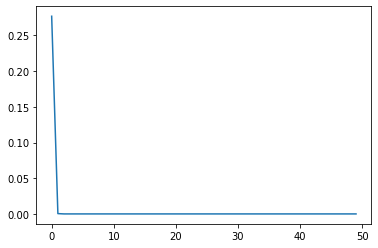

1.0


In [16]:
def upd(dk,data):
    if dk==0:
        dk=data
    else:
        for ky in data.keys():
            dk[ky].extend(data[ky])
    return dk
for index in range(1,6):
  best_accuracy_last={}
  final_accuracy_last={}
  history_last={}
  answers_last={}
  predictions_last={}
  predictions_last_best={}
  times_last={}
  epoch=50
  pre_acc=0
  best=0
  fold='fold_'+str(index)
  trn,tst=get_trn_tst(index)
  history_last[fold]=0






  trn=unison_shuffled_copies(trn)
  tst=unison_shuffled_copies(tst)



  model=load_model()


  
  #compiling the model
  model.compile(optimizer=Adam(2e-4,decay=1e-3), 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])
  train_data = DataGenerator(trn, batch_size=4, augment=True)
  test_data = DataGenerator(tst, batch_size=4, augment=False)
  ln=len(trn)
  # del([trn_x,trn_y,trn,tst])
  # gc.collect()
  #fitting the model
  #timing
  start=time.time()
  print('training')
  hist=model.fit_generator(train_data,epochs=50,steps_per_epoch=ln//4,verbose=0)
  history_last[fold]=upd(history_last[fold],hist.history)

  end=time.time()
  times_last[fold]=end-start

  #getting the prediction 
  pre=model.predict(test_data)
  



  #select the maximum position
  pre=np.argmax(pre,1)
  predictions_last[fold]=pre

  
  labels=[]
  for i in tst:
        cls1=i.split('_')[-1].split('.')[0]
        if cls1[-1]=='G':
            labels.append(0)
        else:
            labels.append(1)
  
  #getting the accuracy
  new_acc=accuracy_score(pre,labels)

  


  #storing the predictions
  final_accuracy_last[fold]=new_acc








  #storing the answers
  answers_last[fold]=labels
    
    
    
    
  #freeing memory
  del([train_data,test_data,labels])
  gc.collect()
  model.save_weights('weights.hdf5')
  plt.plot(history_last[fold]['loss'])
  plt.show()
  print(new_acc)
  index=str(index)
  type='final_3535'
  model1='alexnet'
  np.save("/content/gdrive/MyDrive/best_accuracy_all_fold_"+index+"_"+model1+"_"+type+".npy",best_accuracy_last)
  np.save("/content/gdrive/MyDrive/final_accuracy_all_fold"+index+"_"+model1+"_"+type+".npy",final_accuracy_last)
  np.save("/content/gdrive/MyDrive/history_all_fold_"+index+"_"+model1+"_"+type+".npy",history_last)
  np.save("/content/gdrive/MyDrive/answers_all_fold_"+index+"_"+model1+"_"+type+".npy",answers_last)
  np.save("/content/gdrive/MyDrive/predictions_all_fold_"+index+"_"+model1+"_"+type+".npy",predictions_last)
  np.save("/content/gdrive/MyDrive/predictions_all_best_fold_"+index+"_"+model1+"_"+type+".npy",predictions_last_best)
  np.save("/content/gdrive/MyDrive/times_all_fold_"+index+"_"+model1+"_"+type+".npy",times_last)
  del([model])
  gc.collect()